In [1]:
import re
import numpy as np
from collections import Counter

import string

from sklearn.model_selection import train_test_split
from keras import regularizers
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, LSTM, Conv1D, MaxPooling1D

import matplotlib.pyplot as plt
%matplotlib inline

import os
from metrics import make_roc_pr_plot, plot_learning_curves, reverse_embedding
from sklearn.metrics import precision_recall_curve, roc_curve, auc

Using TensorFlow backend.


In [2]:
#def remove_punctuation(s):
#    regex = re.compile('[%s]' % re.escape(string.punctuation))
#    return regex.sub('', s)

#def replace_numbers(s):
#    s = re.sub("\d", "x", s)
#    return s

#def clean_string(s):
#    """
#    string cleaning for dataset
#    Every dataset is lower cased except
#    """
#    s = remove_punctuation(s)
#    s = replace_numbers(s)
#    return s

def remove_space_before_comma_and_period(s):
    """
    This function removes the space before commas and periods. The spaces are probably 
    placed to make machine processing easier, but I would like the formatting to be consistent
    with normal use to I can reuse functions for cleaning strings.
    """
    return re.sub("\s,", ',', s)

def define_vocabulary(no_comma_sentences, max_vocab):
    """
        0 is used for no word
        1 is used for word unknown
        So vocabulary stats at 2
    """
    corpus = ' '.join(no_comma_sentences)
    c = Counter(corpus.split())
    vocab_len = len(c)+2
    most_common_words = c.most_common(max_vocab)
    vocabulary = {}
    reverse_vocabulary = {}
    for idx, item in enumerate(most_common_words):
        word = item[0]
        vocabulary[word] = idx+2
        reverse_vocabulary[idx+2] = word
    return vocabulary, reverse_vocabulary

def get_y(sentence, max_len):
    words = sentence.split()
    y = np.zeros((1, max_len))
    for idx, word in enumerate(words):
        if (',' in word) and (idx<max_len-1):
            y[0, idx] = 1
                
    return y

def embed_sentence(sentence, vocabulary, max_len):
    embedded = []
    try:
        sentence_crop = sentence.split()[:max_len]
    except:
        sentence_crop = sentence.split()
    for word in sentence_crop:
        if word in vocabulary:
            word_idx = vocabulary[word]
            embedded.append(word_idx)
        else:
            embedded.append(1)
    while len(embedded)<max_len:
        embedded.append(0)
    return embedded


def pre_process(sentences, max_len, vocabulary):
    X = []
    Y = []
    for sentence in sentences:
        sentence = remove_space_before_comma_and_period(sentence)
        try:
            y = get_y(sentence, max_len)
        except:
            print(sentence)
            print(len(sentence.split()))
            break
        sentence = sentence.replace(',', '')
        embedded_sentence = embed_sentence(sentence, vocabulary, max_len)
        X.append(embedded_sentence)
        Y.append(y)
    Y = np.concatenate(Y, axis=0)
    return X, Y        

In [3]:
max_len = 50
max_vocab = 5000
num_datafiles = 60
EMBEDDING_DIM = 128 
DROPOUT_RATE = 0.5
epochs = 10
batch_size = 16

In [4]:
path_to_files = 'corpera/europarl_raw/danish/'
all_files = [files for (path, dirs, files) in os.walk(path_to_files)][0]
all_sentences = []
for file in all_files[:num_datafiles]:
    if file.endswith(".da"):
        with open(path_to_files + file) as f:
            sentences = f.readlines()
            for sentence in sentences:
                all_sentences.append(sentence)
                
print(len(all_sentences))

136669


In [5]:
cleaned_sentences = [remove_space_before_comma_and_period(sentence) for sentence in all_sentences]
vocabulary, reverse_vocabulary = define_vocabulary(cleaned_sentences, max_vocab)

In [6]:
X, Y = pre_process(all_sentences, max_len, vocabulary)

# Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [8]:
model = Sequential()
model.add(Embedding(len(vocabulary)+2, EMBEDDING_DIM, input_length=max_len))
model.add(Dropout(DROPOUT_RATE))
model.add(Conv1D(filters=64,
                 kernel_size=5,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(50))
model.add(Dense(max_len))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 128)           640256    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 46, 64)            41024     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 11, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                23000     
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
Total para

In [10]:
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test))

Train on 123002 samples, validate on 13667 samples
Epoch 1/10
123002/123002 [==============================] - 308s - loss: 0.1065 - acc: 0.9667 - val_loss: 0.0872 - val_acc: 0.9719
Epoch 2/10
123002/123002 [==============================] - 303s - loss: 0.0783 - acc: 0.9746 - val_loss: 0.0708 - val_acc: 0.9776
Epoch 3/10
123002/123002 [==============================] - 306s - loss: 0.0671 - acc: 0.9783 - val_loss: 0.0627 - val_acc: 0.9801
Epoch 4/10
123002/123002 [==============================] - 301s - loss: 0.0604 - acc: 0.9805 - val_loss: 0.0570 - val_acc: 0.9819
Epoch 5/10
123002/123002 [==============================] - 307s - loss: 0.0551 - acc: 0.9825 - val_loss: 0.0527 - val_acc: 0.9840
Epoch 6/10
123002/123002 [==============================] - 298s - loss: 0.0511 - acc: 0.9840 - val_loss: 0.0488 - val_acc: 0.9853
Epoch 7/10
123002/123002 [==============================] - 299s - loss: 0.0479 - acc: 0.9852 - val_loss: 0.0470 - val_acc: 0.9860
Epoch 8/10
123002/123002 [======

Final training loss   0.0425806657674
Final validation loss 0.0424179007514


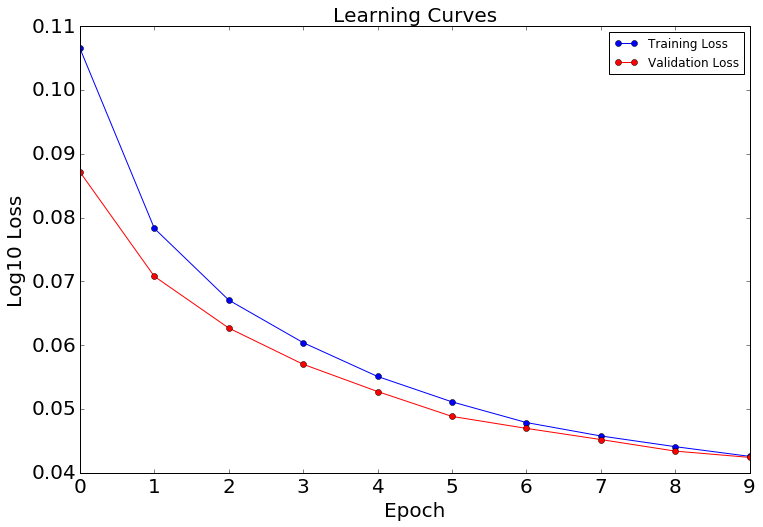

In [11]:
plot_learning_curves(history)

In [12]:
y_hat = model.predict_proba(X_test)

13536/13667 [============================>.] - ETA: 0s

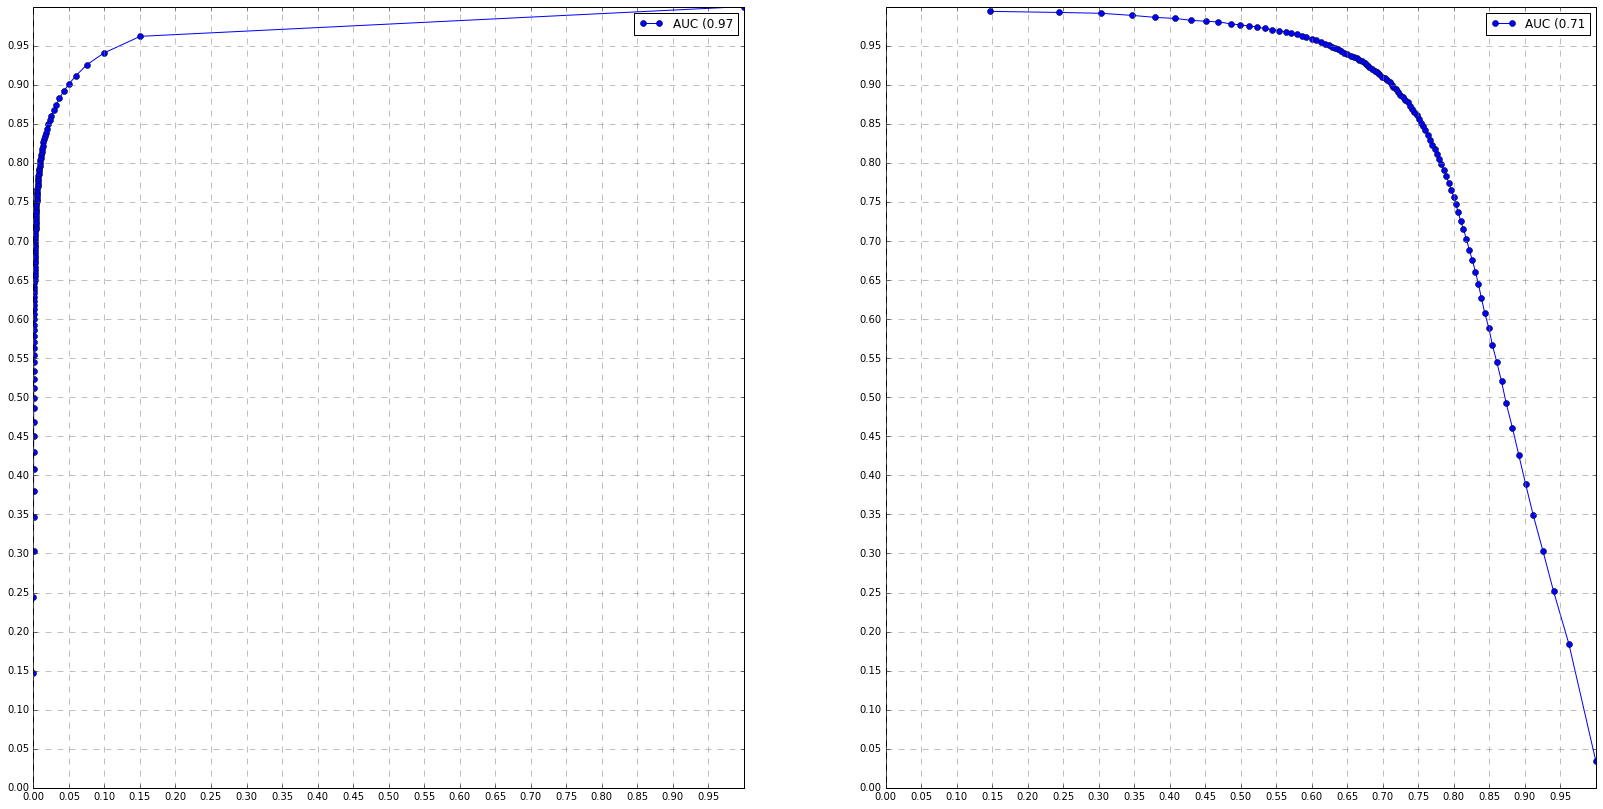

In [13]:
make_roc_pr_plot(y_test, y_hat)

# Get the optimal threshold by doing f1 analysis

In [14]:
import metrics

In [15]:
def get_optimal_threshold(precision, recall, thresholds):
    f1_score = 2*(precision*recall)/(precision+recall)
    max_idx = np.where(f1_score == np.nanmax(f1_score))
    threshold = thresholds[max_idx]
    precision_at_threshold = precision[max_idx]
    recall_at_threshold = recall[max_idx]
    return threshold, precision_at_threshold, recall_at_threshold

In [16]:
precision, recall, _ = metrics.pr_analysis(y_test, y_hat)

In [17]:
thresholds = np.arange(0,1,0.01)

In [18]:
best_threshold, precision_at_threshold, recall_at_threshold = get_optimal_threshold(precision, recall, thresholds)

In [19]:
print('Threshold: {:0}, precision: {:1.2f}, recall: {:2.2f}'.format(best_threshold[0],
                                                              precision_at_threshold[0],
                                                              recall_at_threshold[0]))

Threshold: 0.41000000000000003, precision: 0.86, recall: 0.74


# Write function that gets a fp or fn from the test set

In [20]:
reverse_vocabulary[0] = ''
reverse_vocabulary[1] = 'UNKNOWN'

In [21]:
idx = 15
reverse_embedding(X_test[idx], y_test[idx], reverse_vocabulary, y_hat[idx], threshold=0.4)

Desuden vil jeg gerne sige, [tp] at vi kan lære af fortiden .                                      


## Testing the reverse embed

# Write function that takes arbirary string as input

In [22]:
all_sentences[1]

'Godkendelse af protokollen fra foregående møde Protokollen fra mødet i går er omdelt .\n'

In [23]:
def embed_sentence(sentence, vocabulary, max_len):
    embedded = []
    unknown_words = []
    try:
        sentence_crop = sentence.split()[:max_len]
    except:
        sentence_crop = sentence.split()
    for word in sentence_crop:
        if word in vocabulary:
            word_idx = vocabulary[word]
            embedded.append(word_idx)
        else:
            embedded.append(1)
            unknown_words.append(word)
    while len(embedded)<max_len:
        embedded.append(0)
    return embedded, unknown_words

In [61]:
def reverse_embedding(x, y, reverse_vocabulary, y_hat = None, threshold=0.9):
    """
        Inputs
        x: An array of embedded words. 
        y: The target for the embedded words. This is an binary vector of the same 
        length as x. The elements of the vector are 1 is a comma should be placed 
        after the word and 0 otherwise.
        reverse_vocabulary: A dictionary mapping embedded words to real words.
        y_hat: (Optional) A vector similar to y, but each element contains the
        probability that a comma should be placed after the word.
        threshold: The probability threshold that is used to make y_hat a binary 
        vector. 

        Output:
        Prints the sentence with the correct (ground truth) commas. If y_hat is
        supplied it also evaulates true positives, false positives and false negatives.
    """
    if y_hat is None:
        words = [reverse_vocabulary[int_rep] for int_rep in x]
        idx = np.where(y==1)[0][0]
        words[idx] = words[idx]+',' 
        print(' '.join(words))
    if (y is None) and (y_hat is not None) :
        words = [reverse_vocabulary[int_rep] for int_rep in x]
        idx_pred = np.where(y_hat>threshold)[1]
        for idx in idx_pred:
            words[idx] = words[idx]+' ,'
        return_text = ' '.join(words)
        return return_text
    else:
        words = [reverse_vocabulary[int_rep] for int_rep in x]
        idx_true = np.where(y==1)[0]
        idx_pred = np.where(y_hat>threshold)[0]
        for true_idx in idx_true:
            if true_idx in idx_pred:
                words[true_idx] = words[true_idx]+', [tp]'
            else:
                words[true_idx] = words[true_idx]+', [fn]'
        for pred_idx in idx_pred:
            if pred_idx not in idx_true:
                words[pred_idx] = words[pred_idx]+', [fp]'
        print(' '.join(words))

In [62]:
def format_as_EU(text):
    text = text.replace('.',' .')
    text = text.replace('"',' " ')
    text = text.replace(',',' ,')
    text = re.sub("\s{2}", " ", text)
    return text

def make_prediction_from_raw(text, vocabulary, max_len, model, threshold):
    print('Raw input:')
    print(text)
    text = format_as_EU(text)
    print('EU formatting:')
    print(text)
    text = remove_space_before_comma_and_period(text)
    print('remove space before comma:')
    print(text)
    y = get_y(text, max_len)
    print('y is: (we dont use this now, but will perhaps later.)')
    print(y)
    text = text.replace(',', '')
    print('Remove commas before embedding:')
    print(text)
    x_embed, unknown_words = embed_sentence(text, vocabulary, max_len)
    print('Unknown words:', unknown_words)
    # Should return a list with the words that are mapped into NUMBER
    x_embed = np.array(x_embed).reshape(1, max_len)
    print('After embedding:')
    print(x_embed)
    print('Make prediction:')
    y_hat = model.predict_proba(x_embed)
    print('Comma is suggested to be placed after index:')
    print(np.where(y_hat>threshold)[1])
    print('After reversing embedding and predicted commas included:')
    return_text = reverse_embedding(x_embed[0], None, reverse_vocabulary, y_hat, threshold)
    print(return_text)
    print('Adding in the UNKNOWN words:')
    return_text = return_text.split(' ')
    ii = 0
    for idx, word in enumerate(return_text):
        if word=='UNKNOWN':
            return_text[idx] = unknown_words[ii]
            ii += 1
    return_text= ' '.join(return_text).rstrip()
    print(return_text)
    return_text = remove_space_before_comma_and_period(return_text)
    print(return_text)

In [68]:
example = 'Hvad nu hvis min sætning er meget meget lang og fuld af underlige ord så som "hobbyhest" og fedtøre"?'
make_prediction_from_raw(example, vocabulary, max_len, model, best_threshold)

Raw input:
Hvad nu hvis min sætning er meget meget lang og fuld af underlige ord så som "hobbyhest" og fedtøre"?
EU formatting:
Hvad nu hvis min sætning er meget meget lang og fuld af underlige ord så som " hobbyhest " og fedtøre " ?
remove space before comma:
Hvad nu hvis min sætning er meget meget lang og fuld af underlige ord så som " hobbyhest " og fedtøre " ?
y is: (we dont use this now, but will perhaps later.)
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
Remove commas before embedding:
Hvad nu hvis min sætning er meget meget lang og fuld af underlige ord så som " hobbyhest " og fedtøre " ?
Unknown words: ['sætning', 'underlige', 'hobbyhest', 'fedtøre']
After embedding:
[[237  86  69  91   1   6  47  47 603   4 798   7   1 536  38  12  64   1
   64   4   1  64  67   0   0   0   0   0   0   0   0   0   0   0   0   0
    